In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data_path = '/content/drive/MyDrive/Forest_Fire_Data/updated/Gases_BC_Meteo_Merged_Final.csv'

# Read the csv using pandas
Gases_BC_Meteo_Merged_Final = pd.read_csv(data_path)

## Data Pre Processing

In [ ]:
Gases_BC_Meteo_Merged_Final.head()

,start_time,WS_ave(m/s),WD_ave(deg),T_air(C),RH(-),P_air(hPa),fireOccFlag,BC-mass-filter,BC-mass,BC-mass-from-trasm,CO_Calib,CO_sync_std,CO2_Calib,CO2_dry_sync_std,CH4_Calib,CH4_dry_sync_std,decimal_time
0,0.000000,0.8,108.0,10.8,65.2,1014.0,0,0.91969,0.12561,0.24372,138.632014,0.003847,426.737303,0.199903,2001.065258,0.001887,0.000000
1,0.000694,1.7,123.0,10.8,65.4,1014.0,0,0.92318,0.20912,0.31443,136.750922,0.004481,427.041097,0.546126,2001.475209,0.001885,0.000694
2,0.001389,1.0,173.0,10.7,65.4,1014.1,0,0.92548,0.13826,0.16940,134.349790,0.004593,426.280409,0.570615,2000.796653,0.004286,0.001389
3,0.002083,1.1,267.0,10.7,65.5,1014.1,0,0.92741,0.11548,0.24859,136.189279,0.005584,426.404599,0.457248,2000.613047,0.002020,0.002083
4,0.002778,1.1,267.0,10.6,65.7,1014.1,0,0.92976,0.14144,0.21111,135.983034,0.005379,427.523589,0.714412,2002.635428,0.002697,0.002778


In [ ]:
Gases_BC_Meteo_Merged_Final = Gases_BC_Meteo_Merged_Final.drop(columns=['decimal_time'])

In [ ]:
Gases_BC_Meteo_Merged_Final.columns

Index(['start_time', 'WS_ave(m/s)', 'WD_ave(deg)', 'T_air(C)', 'RH(-)',
       'P_air(hPa)', 'fireOccFlag', 'BC-mass-filter', 'BC-mass',
       'BC-mass-from-trasm', 'CO_Calib', 'CO_sync_std', 'CO2_Calib',
       'CO2_dry_sync_std', 'CH4_Calib', 'CH4_dry_sync_std'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Count NaN values in each column
nan_counts = Gases_BC_Meteo_Merged_Final.isna().sum()

# Display the count of NaN values for each column
print("NaN Counts:\n", nan_counts)

# Remove rows with NaN values
Gases_BC_Meteo_Merged_Final = Gases_BC_Meteo_Merged_Final.dropna()

NaN Counts:
 start_time               0
WS_ave(m/s)           2501
WD_ave(deg)           2501
T_air(C)              2515
RH(-)                 2529
P_air(hPa)            2509
fireOccFlag              0
BC-mass-filter           0
BC-mass                  0
BC-mass-from-trasm       0
CO_Calib                 0
CO_sync_std              0
CO2_Calib                0
CO2_dry_sync_std         0
CH4_Calib                0
CH4_dry_sync_std         0
dtype: int64


In [ ]:
# Count occurrences of 0 and 1 in the 'label' column
label_counts = Gases_BC_Meteo_Merged_Final['fireOccFlag'].value_counts()

# Display the counts
print("Count of 0:", label_counts[0])
print("Count of 1:", label_counts[1])

Count of 0: 300465
Count of 1: 205112


In [ ]:
specific_column = 'fireOccFlag'

# Get a list of column names excluding the specific column
columns_to_keep = [col for col in Gases_BC_Meteo_Merged_Final.columns if col != specific_column]

# Reorder the columns by first keeping all columns except the specific one and then adding it at the end
new_columns_order = columns_to_keep + [specific_column]

# Create a new DataFrame with columns reordered
Gases_BC_Meteo_Merged_Final = Gases_BC_Meteo_Merged_Final[new_columns_order]

In [ ]:
# Calculate correlation matrix
corr_matrix = Gases_BC_Meteo_Merged_Final.corr(method='spearman')  # Use Spearman's rank correlation for non-normal data

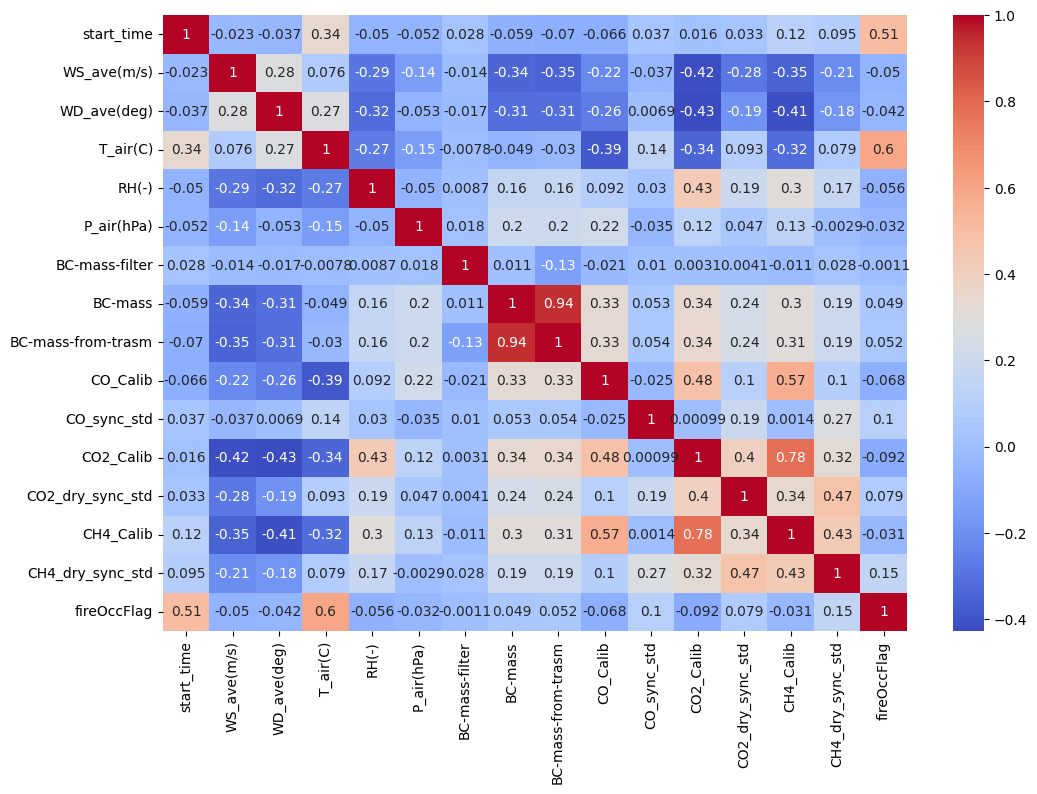

In [ ]:
import matplotlib.pyplot as plt

# Use a library like seaborn for nicer plots
import seaborn as sns

# Create the correlation plot (change colormap as desired)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [ ]:

features = Gases_BC_Meteo_Merged_Final.drop('fireOccFlag', axis=1).values

labels = Gases_BC_Meteo_Merged_Final['fireOccFlag'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=47)



In [ ]:
# Extract time series sequence (assuming it's in the first column)
X_train_sequence = X_train[:, 0].reshape(-1, 1)
X_val_sequence = X_test[:, 0].reshape(-1, 1)

# Extract non-temporal features (assuming they start from the second column)
X_train_features = X_train[:, 1:]
X_val_features = X_test[:, 1:]
y_val = y_test

# Define validation data (assuming you have X_val_sequence, X_val_features, and y_val)
validation_data = ({'input_sequence': X_val_sequence, 'input_features': X_val_features}, y_val)

In [ ]:
# Define the directory in Google Drive to save the model
model_directory = '/content/drive/MyDrive/Forest_Fire_Data/saved_models'

# **LSTM - Fire Detection**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate


# Input layer for time series sequence
input_sequence = Input(shape=(X_train_sequence.shape[1], 1), name='input_sequence')
lstm_layer = LSTM(50)(input_sequence)  # Adjust the number of LSTM units as needed

# Input layer for non-temporal features
input_features = Input(shape=(X_train_features.shape[1],), name='input_features')

# Concatenate LSTM output and non-temporal features
concatenated = Concatenate()([lstm_layer, input_features])

# Dense layers for classification
dense_layer_1 = Dense(64, activation='relu')(concatenated)
output_layer = Dense(1, activation='sigmoid')(dense_layer_1)  # For binary classification

# Create the model
model_lstm = Model(inputs=[input_sequence, input_features], outputs=output_layer)

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define number of epochs
epochs = 15  # You can adjust this based on your specific requirements
batch_size = 42  # You can adjust this based on your specific requirements

# Define validation data (assuming you have X_val_sequence, X_val_features, and y_val)
validation_data = ({'input_sequence': X_val_sequence, 'input_features': X_val_features}, y_val)

# Train the model using X_train_sequence and X_train_features
historty = model_lstm.fit({'input_sequence': X_train_sequence, 'input_features': X_train_features}, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)


Epoch 1/15
9631/9631 [==============================] - 55s 5ms/step - loss: 0.5430 - accuracy: 0.8294 - val_loss: 0.7290 - val_accuracy: 0.7523
Epoch 2/15
9631/9631 [==============================] - 59s 6ms/step - loss: 0.3905 - accuracy: 0.8583 - val_loss: 0.2720 - val_accuracy: 0.9045
Epoch 3/15
9631/9631 [==============================] - 51s 5ms/step - loss: 0.3473 - accuracy: 0.8727 - val_loss: 0.5403 - val_accuracy: 0.7995
Epoch 4/15
9631/9631 [==============================] - 49s 5ms/step - loss: 0.3209 - accuracy: 0.8818 - val_loss: 0.2575 - val_accuracy: 0.8960
Epoch 5/15
9631/9631 [==============================] - 50s 5ms/step - loss: 0.2884 - accuracy: 0.8927 - val_loss: 0.2323 - val_accuracy: 0.9124
Epoch 6/15
9631/9631 [==============================] - 49s 5ms/step - loss: 0.2537 - accuracy: 0.9049 - val_loss: 0.2320 - val_accuracy: 0.9153
Epoch 7/15
9631/9631 [==============================] - 56s 6ms/step - loss: 0.2296 - accuracy: 0.9127 - val_loss: 0.1883 - val_ac

In [ ]:
# Save the model
model_name = 'LSTM_FireDetection.h5'

# Save the model to Google Drive with the custom name
model_lstm.save(model_directory + model_name)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sequence (InputLayer  [(None, 1, 1)]               0         []                            
 )                                                                                                
                                                                                                  
 lstm (LSTM)                 (None, 50)                   10400     ['input_sequence[0][0]']      
                                                                                                  
 input_features (InputLayer  [(None, 14)]                 0         []                            
 )                                                                                                
                                                                                              

In [ ]:
# Print the final training accuracy
print("Final Training Accuracy:", historty.history['accuracy'][-1])

# Print the final validation accuracy
print("Final Validation Accuracy:", historty.history['val_accuracy'][-1])

Final Training Accuracy: 0.9258915185928345
Final Validation Accuracy: 0.9361624121665955


# **GRU**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate

# Input layer for time series sequence using GRU
input_sequence = Input(shape=(X_train_sequence.shape[1], 1), name='input_sequence')
gru_layer = GRU(50)(input_sequence)  # Adjust the number of GRU units as needed

# Input layer for non-temporal features
input_features = Input(shape=(X_train_features.shape[1],), name='input_features')

# Concatenate GRU output and non-temporal features
concatenated = Concatenate()([gru_layer, input_features])

# Dense layers for classification
dense_layer_1 = Dense(64, activation='relu')(concatenated)
output_layer = Dense(1, activation='sigmoid')(dense_layer_1)  # For binary classification

# Create the model
model_Gru = Model(inputs=[input_sequence, input_features], outputs=output_layer)

# Print the summary of the GRU model
model_Gru.summary()

# Compile the model
model_Gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define number of epochs and batch size
epochs = 15  # You can adjust this based on your specific requirements
batch_size = 42  # You can adjust this based on your specific requirements


# Train the model using X_train_sequence and X_train_features
history_Gru = model_Gru.fit({'input_sequence': X_train_sequence, 'input_features': X_train_features}, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sequence (InputLayer  [(None, 1, 1)]               0         []                            
 )                                                                                                
                                                                                                  
 gru (GRU)                   (None, 50)                   7950      ['input_sequence[0][0]']      
                                                                                                  
 input_features (InputLayer  [(None, 14)]                 0         []                            
 )                                                                                                
                                                                                            

In [ ]:
# Save the model
model_name = 'GRU_FireDetection.h5'

# Save the model to Google Drive with the custom name
model_Gru.save(model_directory + model_name)

In [ ]:
# Print the final training accuracy
print("Final Training Accuracy GRU:", history_Gru.history['accuracy'][-1])

# Print the final validation accuracy
print("Final Validation Accuracy GRU:", history_Gru.history['val_accuracy'][-1])

Final Training Accuracy GRU: 0.9270461201667786
Final Validation Accuracy GRU: 0.939287543296814


# **Bidirrectional LSTM - Fire Detection**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Concatenate


# Input layer for time series sequence using Bidirectional LSTM
input_sequence = Input(shape=(X_train_sequence.shape[0], 1), name='input_sequence')
bidirectional_lstm_layer = Bidirectional(LSTM(50))(input_sequence)  # Adjust the number of LSTM units as needed
# Input layer for non-temporal features
input_features = Input(shape=(X_train_features.shape[1],), name='input_features')

# Concatenate Bidirectional LSTM output and non-temporal features
concatenated = Concatenate()([bidirectional_lstm_layer, input_features])

# Dense layers for classification
dense_layer_1 = Dense(64, activation='relu')(concatenated)
output_layer = Dense(1, activation='sigmoid')(dense_layer_1)  # For binary classification

# Create the model
model_bi_d_lstm = Model(inputs=[input_sequence, input_features], outputs=output_layer)

# Print the summary of the Bidirectional LSTM model
model_bi_d_lstm.summary()

# Compile the model
model_bi_d_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define number of epochs and batch size
epochs = 15  # You can adjust this based on your specific requirements
batch_size = 42  # You can adjust this based on your specific requirements

# Train the model using X_train_sequence and X_train_features
history_bi_d_lstm=model_bi_d_lstm.fit({'input_sequence': X_train_sequence, 'input_features': X_train_features}, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

# Save the model
model_name = 'Bi_LSTM_FireDetection.h5'

# Save the model to Google Drive with the custom name
model_bi_d_lstm.save(model_directory + model_name)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sequence (InputLayer  [(None, 404461, 1)]          0         []                            
 )                                                                                                
                                                                                                  
 bidirectional (Bidirection  (None, 100)                  20800     ['input_sequence[0][0]']      
 al)                                                                                              
                                                                                                  
 input_features (InputLayer  [(None, 14)]                 0         []                            
 )                                                                                          

In [ ]:
# Print the final training accuracy
print("Final Training Accuracy Bi directional LSTM:", history_bi_d_lstm.history['accuracy'][-1])

# Print the final validation accuracy
print("Final Validation Accuracy Bi directional LSTM:", history_bi_d_lstm.history['val_accuracy'][-1])

Final Training Accuracy Bi directional LSTM: 0.9292070269584656
Final Validation Accuracy Bi directional LSTM: 0.9128229022026062


# **Temporal Convolutional Networks (TCN) - Fire Detection**

In [ ]:
pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.8 MB/s eta 0:00:00


In [ ]:
X_train_sequence.shape[0]

404461

In [ ]:
# Input layer for time series sequence using 1D Convolutional Layer
input_sequence = Input(shape=(X_train_sequence.shape[0], 1), name='input_sequence')

In [ ]:
input_sequence

<KerasTensor: shape=(None, 404461, 1) dtype=float32 (created by layer 'input_sequence')>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate
from tcn import TCN

# Assuming X_train_sequence, X_train_features, y_train are properly defined
# ...


# Convolutional layer
conv1d_layer = Conv1D(filters=64, kernel_size=1, activation='relu')(input_sequence)

# Temporal Convolutional Network (TCN) layer
tcn_layer = TCN(return_sequences=False)(conv1d_layer)

# Input layer for non-temporal features
input_features = Input(shape=(X_train_features.shape[1],), name='input_features')

# Concatenate TCN output and non-temporal features
concatenated = concatenate([tcn_layer, input_features])

# Dense layers for classification
dense_layer_1 = Dense(64, activation='relu')(concatenated)
output_layer = Dense(1, activation='sigmoid')(dense_layer_1)  # For binary classification

# Create the model
model_tcn = Model(inputs=[input_sequence, input_features], outputs=output_layer)

# Print the summary of the TCN model
model_tcn.summary()

# Compile the model
model_tcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using X_train_sequence and X_train_features
history_tcn = model_tcn.fit({'input_sequence': X_train_sequence, 'input_features': X_train_features}, y_train, epochs=15, batch_size=42, validation_data=validation_data)

# Save the model
model_name = 'TCN_FireDetection.h5'

# Save the model to Google Drive with the custom name
model_tcn.save(model_directory + model_name)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sequence (InputLayer  [(None, 404461, 1)]          0         []                            
 )                                                                                                
                                                                                                  
 conv1d (Conv1D)             (None, 404461, 64)           128       ['input_sequence[0][0]']      
                                                                                                  
 tcn (TCN)                   (None, 64)                   148224    ['conv1d[0][0]']              
                                                                                                  
 input_features (InputLayer  [(None, 14)]                 0         []                      

In [ ]:
# Print the final training accuracy
print("Final Training Accuracy TCN:", history_tcn.history['accuracy'][-1])

# Print the final validation accuracy
print("Final Validation Accuracy TCN:", history_tcn.history['val_accuracy'][-1])

Final Training Accuracy TCN: 0.9375143647193909
Final Validation Accuracy TCN: 0.9400985240936279


# **Combined Bidirectional LSTM (BiLSTM) and GRU - Fire Detection**

In [ ]:

features = Gases_BC_Meteo_Merged_Final.drop('fireOccFlag', axis=1).values

labels = Gases_BC_Meteo_Merged_Final['fireOccFlag'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=62)

# Extract time series sequence (assuming it's in the first column)
X_train_time = X_train[:, 0].reshape(-1, 1)
X_test_time = X_test[:, 0].reshape(-1, 1)

# Extract non-temporal features (assuming they start from the second column)
X_train_features = X_train[:, 1:]
X_test_features = X_test[:, 1:]


# Define validation data (assuming you have X_val_sequence, X_val_features, and y_val)
validation_data_updated = ({ 'features_input_updated': X_test_features,'time_input_updated': X_test_time}, y_test)

In [ ]:
X_test_time.shape

(151674, 1)

In [ ]:
validation_data_updated

({'features_input_updated': array([[3.10000000e+00, 2.34000000e+02, 2.18000000e+01, ...,
          4.15516232e+00, 1.99695042e+03, 2.94090100e-03],
         [2.00000000e-01, 1.51000000e+02, 2.55000000e+01, ...,
          6.18398448e-01, 2.14050168e+03, 5.51431400e-03],
         [2.30000000e+00, 5.60000000e+01, 1.92000000e+01, ...,
          4.96795006e-01, 2.00992233e+03, 3.18457400e-03],
         ...,
         [1.30000000e+00, 2.24000000e+02, 2.08000000e+01, ...,
          3.61569183e-01, 1.95202410e+03, 4.99881700e-03],
         [3.20000000e+00, 5.90000000e+01, 1.11000000e+01, ...,
          3.55831192e+00, 2.07914718e+03, 4.12198900e-03],
         [6.20000000e+00, 9.00000000e+01, 2.36000000e+01, ...,
          4.75085508e-01, 1.98373738e+03, 3.85370900e-03]]),
  'time_input_updated': array([[160.747917],
         [188.858333],
         [277.001389],
         ...,
         [129.742361],
         [325.9375  ],
         [275.299306]])},
 array([0, 1, 1, ..., 0, 0, 1]))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers


# Standardize the features
scaler_features = StandardScaler()
X_train_features = scaler_features.fit_transform(X_train_features)
X_test_features = scaler_features.transform(X_test_features)

# Standardize the time sequence
scaler_time = StandardScaler()
X_train_time = scaler_time.fit_transform(X_train_time.reshape(-1, 1))
X_test_time = scaler_time.transform(X_test_time.reshape(-1, 1))


from tensorflow.keras import layers, models, optimizers

def create_bilstm_gru_model1(input_shape_features, input_shape_time):
    features_input = layers.Input(shape=input_shape_features, name='features_input')
    time_input = layers.Input(shape=input_shape_time, name='time_input')

    # BiLSTM layers with dropout
    lstm_out = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(features_input)
    lstm_out = layers.Dropout(0.3)(lstm_out)
    lstm_out = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(lstm_out)
    lstm_out = layers.Dropout(0.3)(lstm_out)

    # GRU layers with dropout
    gru_out = layers.GRU(32, return_sequences=True)(lstm_out)
    gru_out = layers.Dropout(0.3)(gru_out)
    gru_out = layers.GRU(32)(gru_out)
    gru_out = layers.Dropout(0.3)(gru_out)

    # Combining the outputs
    combined = layers.concatenate([gru_out, time_input])

    # Dense layers with batch normalization and dropout
    dense_out = layers.Dense(64, activation='relu')(combined)
    dense_out = layers.BatchNormalization()(dense_out)
    dense_out = layers.Dropout(0.3)(dense_out)

    dense_out = layers.Dense(32, activation='relu')(dense_out)
    dense_out = layers.BatchNormalization()(dense_out)
    dense_out = layers.Dropout(0.3)(dense_out)

    # Output layer
    output = layers.Dense(1, activation='sigmoid', name='output')(dense_out)

    # Creating the model
    model_combined_gru_lstm = models.Model(inputs=[features_input, time_input], outputs=output)

    # Compiling the model
    model_combined_gru_lstm.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                                    loss='binary_crossentropy',
                                    metrics=['accuracy'])

    return model_combined_gru_lstm


# Create and compile the model
model_combined_gru_lstm = create_bilstm_gru_model1((X_train_features.shape[1], 1), (1,))

# Train the model
history_model_lstm_gru_combined = model_combined_gru_lstm.fit([X_train_features, X_train_time], y_train, epochs=20, batch_size=42)


# Save the model
model_name = 'BiLSTM_GRU_Combined_FireDetection_new.h5'

# Save the model to Google Drive with the custom name
model_combined_gru_lstm.save(model_directory + model_name)

Epoch 1/20
8427/8427 [==============================] - 150s 16ms/step - loss: 0.2067 - accuracy: 0.9241
Epoch 2/20
8427/8427 [==============================] - 133s 16ms/step - loss: 0.1640 - accuracy: 0.9395
Epoch 3/20
8427/8427 [==============================] - 131s 15ms/step - loss: 0.1292 - accuracy: 0.9523
Epoch 4/20
8427/8427 [==============================] - 133s 16ms/step - loss: 0.1011 - accuracy: 0.9644
Epoch 5/20
8427/8427 [==============================] - 132s 16ms/step - loss: 0.0808 - accuracy: 0.9721
Epoch 6/20
8427/8427 [==============================] - 133s 16ms/step - loss: 0.0715 - accuracy: 0.9757
Epoch 7/20
8427/8427 [==============================] - 140s 17ms/step - loss: 0.0614 - accuracy: 0.9788
Epoch 8/20
8427/8427 [==============================] - 134s 16ms/step - loss: 0.0528 - accuracy: 0.9822
Epoch 9/20
8427/8427 [==============================] - 131s 16ms/step - loss: 0.0479 - accuracy: 0.9836
Epoch 10/20
8427/8427 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model on the test set
Test_accuracy = model_combined_gru_lstm.evaluate([X_test_features, X_test_time], y_test)[1]


4740/4740 [==============================] - 31s 6ms/step - loss: 0.0188 - accuracy: 0.9930


In [ ]:
# Print the final training accuracy
print("Final Training Accuracy model_combined_gru_lstm:", history_model_lstm_gru_combined.history['accuracy'][-1])
print("Final Testing Accuracy model_combined_gru_lstm:", Test_accuracy)

Final Training Accuracy model_combined_gru_lstm: 0.9911303520202637
Final Testing Accuracy model_combined_gru_lstm: 0.9930245280265808


# **Combined BiLSTM and TCN - Fire Detection**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tcn import TCN


# Define the BiLSTM with TCN model
def create_bilstm_tcn_model(input_shape, time_sequence_shape):
    features_input = layers.Input(shape=input_shape, name='features_input_updated')
    time_sequence_input = layers.Input(shape=time_sequence_shape, name='time_input_updated')

    # Bidirectional LSTM layer
    lstm_out = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(features_input)

    # Convolutional layer
    conv_out = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(lstm_out)
    conv_out = layers.BatchNormalization()(conv_out)
    conv_out = layers.Activation('relu')(conv_out)

    # TCN layer
    tcn_out = TCN(nb_filters=64, kernel_size=2, dilations=[1, 2, 4, 8, 16, 32], return_sequences=True)(conv_out)
    tcn_out = layers.GlobalMaxPooling1D()(tcn_out)

    # Concatenate with time sequence
    combined = layers.concatenate([tcn_out, time_sequence_input])

    # Dense layers
    dense_out = layers.Dense(64, activation='relu')(combined)
    output = layers.Dense(1, activation='sigmoid', name='output')(dense_out)

    model_TCN_biLSTM_combined = keras.Model(inputs=[features_input, time_sequence_input], outputs=output)
    model_TCN_biLSTM_combined.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_TCN_biLSTM_combined

# Create and compile the model
model_TCN_biLSTM_combined = create_bilstm_tcn_model((X_train_features.shape[1], 1), (1,))

# Train the model
history_TCN_biLSTM_combined = model_TCN_biLSTM_combined.fit([X_train_features, X_train_time], y_train, epochs=15, batch_size=42)

# Save the model
model_name = 'BiLSTM_TCN_Combined_FireDetection.h5'

# Save the model to Google Drive with the custom name
model_TCN_biLSTM_combined.save(model_directory + model_name)

Epoch 1/15
8427/8427 [==============================] - 492s 57ms/step - loss: 0.1556 - accuracy: 0.9398
Epoch 2/15
8427/8427 [==============================] - 476s 56ms/step - loss: 0.0641 - accuracy: 0.9759
Epoch 3/15
8427/8427 [==============================] - 470s 56ms/step - loss: 0.0463 - accuracy: 0.9830
Epoch 4/15
8427/8427 [==============================] - 476s 57ms/step - loss: 0.0389 - accuracy: 0.9858
Epoch 5/15
8427/8427 [==============================] - 473s 56ms/step - loss: 0.0341 - accuracy: 0.9875
Epoch 6/15
8427/8427 [==============================] - 458s 54ms/step - loss: 0.0310 - accuracy: 0.9885
Epoch 7/15
8427/8427 [==============================] - 445s 53ms/step - loss: 0.0285 - accuracy: 0.9894
Epoch 8/15
8427/8427 [==============================] - 438s 52ms/step - loss: 0.0267 - accuracy: 0.9900
Epoch 9/15
8427/8427 [==============================] - 440s 52ms/step - loss: 0.0254 - accuracy: 0.9906
Epoch 10/15
8427/8427 [==============================] 

In [ ]:
# Evaluate the model on the test set
Test_accuracy = model_TCN_biLSTM_combined.evaluate([X_test_features, X_test_time], y_test)[1]
print(f'Test Accuracy TCN_biLSTM_combined: {Test_accuracy}')

4740/4740 [==============================] - 82s 17ms/step - loss: 0.0263 - accuracy: 0.9902
Test Accuracy TCN_biLSTM_combined: 0.9902092814445496


In [ ]:
# Print the final training accuracy
print("Final Training Accuracy history_TCN_biLSTM_combined:", history_TCN_biLSTM_combined.history['accuracy'][-1])

Final Training Accuracy history_TCN_biLSTM_combined: 0.9924668669700623


# Final Results

## TCN

In [ ]:
from tensorflow.keras.utils import custom_object_scope
from tcn import TCN
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


with custom_object_scope({'TCN': TCN}):
    Loaded_model_tcn = load_model(model_directory+'TCN_FireDetection.h5')


# Evaluate the model on the validation data
loss, accuracy = Loaded_model_tcn.evaluate({'input_sequence': X_val_sequence, 'input_features': X_val_features}, y_val, verbose=0)

# Make predictions on the validation data
y_pred_proba = Loaded_model_tcn.predict({'input_sequence': X_val_sequence, 'input_features': X_val_features})
y_pred = (y_pred_proba > 0.5).astype("int32")  # Converting probabilities to class labels for binary classification

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

3160/3160 [==============================] - 20s 6ms/step
Loss: 0.15619231760501862
Accuracy: 0.9400985240936279
Precision: 0.9452534232577151
Recall: 0.9043382622510082
F1-Score: 0.9243432968185964


In [ ]:
c

## LSTM

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming you have already defined or loaded X_val_sequence, X_val_features, and y_val

# Load the saved model
model_lstm  = load_model(model_directory+'LSTM_FireDetection.h5')

# Ensure the validation data is correctly shaped and normalized (if necessary)
X_val_sequence = X_val_sequence.reshape(-1, X_val_sequence.shape[1], 1)
X_val_features = X_val_features.reshape(-1, X_val_features.shape[1])

# Evaluate the model on the validation data
loss, accuracy = model_lstm.evaluate({'input_sequence': X_val_sequence, 'input_features': X_val_features}, y_val, verbose=0)

# Make predictions on the validation data
y_pred_proba = model_lstm.predict({'input_sequence': X_val_sequence, 'input_features': X_val_features})
y_pred = (y_pred_proba > 0.5).astype("int32")  # Converting probabilities to class labels for binary classification

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


3160/3160 [==============================] - 6s 2ms/step
Loss: 0.16974985599517822
Accuracy: 0.9361624121665955
Precision: 0.9124180190530902
Recall: 0.9316632042038372
F1-Score: 0.921940188407725


## *GRU*

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming you have already defined or loaded X_val_sequence, X_val_features, and y_val

# Load the saved model
model_gru  = load_model(model_directory+'GRU_FireDetection.h5')

# Ensure the validation data is correctly shaped and normalized (if necessary)
X_val_sequence = X_val_sequence.reshape(-1, X_val_sequence.shape[1], 1)
X_val_features = X_val_features.reshape(-1, X_val_features.shape[1])

# Evaluate the model on the validation data
loss, accuracy = model_gru.evaluate({'input_sequence': X_val_sequence, 'input_features': X_val_features}, y_val, verbose=0)

# Make predictions on the validation data
y_pred_proba = model_gru.predict({'input_sequence': X_val_sequence, 'input_features': X_val_features})
y_pred = (y_pred_proba > 0.5).astype("int32")  # Converting probabilities to class labels for binary classification

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

3160/3160 [==============================] - 7s 2ms/step
Loss: 0.15974335372447968
Accuracy: 0.939287543296814
Precision: 0.9307158781273223
Recall: 0.9183184651105951
F1-Score: 0.9244756105062435


## **BiLSTM**

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming you have already defined or loaded X_val_sequence, X_val_features, and y_val

# Load the saved model
model_bi_d_lstm  = load_model(model_directory+'Bi_LSTM_FireDetection.h5')


# Evaluate the model on the validation data
loss, accuracy = model_bi_d_lstm.evaluate({'input_sequence': X_val_sequence, 'input_features': X_val_features}, y_val, verbose=0)

# Make predictions on the validation data
y_pred_proba = model_bi_d_lstm.predict({'input_sequence': X_val_sequence, 'input_features': X_val_features})
y_pred = (y_pred_proba > 0.5).astype("int32")  # Converting probabilities to class labels for binary classification

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

3160/3160 [==============================] - 7s 2ms/step
Loss: 0.2547559440135956
Accuracy: 0.9128229022026062
Precision: 0.8557338534509509
Recall: 0.9436392521080288
F1-Score: 0.8975393163088582


## Bi-LSTM_GRU-Combined

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import StandardScaler


# Standardize the features
scaler_features = StandardScaler()
X_train_features = scaler_features.fit_transform(X_train_features)
X_test_features = scaler_features.transform(X_test_features)

# Standardize the time sequence
scaler_time = StandardScaler()
X_train_time = scaler_time.fit_transform(X_train_time.reshape(-1, 1))
X_test_time = scaler_time.transform(X_test_time.reshape(-1, 1))

# Load the saved model
model_bi_d_lstm_gru  = load_model(model_directory+'BiLSTM_GRU_Combined_FireDetection_new.h5')

# Evaluate the model on the validation data
loss, accuracy = model_bi_d_lstm_gru.evaluate([X_test_features, X_test_time], y_test)

# Make predictions on the validation data
y_pred_proba = model_bi_d_lstm_gru.predict([X_test_features, X_test_time])
y_pred = (y_pred_proba > 0.5).astype("int32")  # Converting probabilities to class labels for binary classification

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

4740/4740 [==============================] - 29s 6ms/step
Loss: 0.018762169405817986
Accuracy: 0.9930245280265808
Precision: 0.9914238378325699
Recall: 0.991391632016632
F1-Score: 0.99140773466305


# ROC Curve

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the directory in Google Drive to save the model
model_directory = '/content/drive/MyDrive/Forest_Fire_Data/saved_models'

# Load the saved models
model_paths = [
    'BiLSTM_GRU_Combined_FireDetection_new.h5',
    'Bi_LSTM_FireDetection.h5',
    'GRU_FireDetection.h5',
    'LSTM_FireDetection.h5',
    'TCN_FireDetection.h55'
]


models = [tf.keras.models.load_model(model_directory+model_path) for model_path in model_paths]



OSError: No file or directory found at /content/drive/MyDrive/Forest_Fire_Data/saved_modelsBiLSTM_GRU_Combined_FireDetection_new.h5

In [ ]:
# Prepare your test data
# Replace 'X_test' and 'y_test' with your actual test data and labels
X_test = ...
y_test = ...

plt.figure()

# Colors for different models
colors = ['darkorange', 'blue', 'green', 'red', 'purple']

for i, model in enumerate(models):
    # Predict probabilities
    y_pred_prob = model.predict(X_test)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Model {i+1} (area = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
